In [26]:
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi

In [27]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
# import getdist
import random
import emcee as mc
# from getdist import plots, MCSamples
import scipy.interpolate as interpolate
import time
from scipy.interpolate import UnivariateSpline
# tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline


# Load data

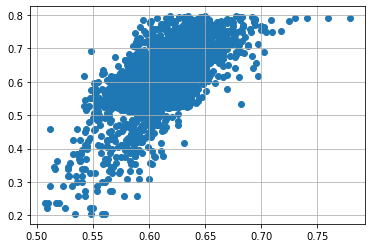

In [28]:
w_data = np.load('./ensemble_cnn/Patches_Ensemble_results_w.npy',
                 allow_pickle=True).item()['ensemble_pred']

w_truth =np.load('./ensemble_cnn/Patches_Ensemble_results_w.npy',
                 allow_pickle=True).item()['truth']

plt.scatter(w_data,w_truth), plt.grid()


hi = -0.33
lo = -1.8
s=0.6

w_truth = (w_truth-(1 - s)*0.5)*(hi-lo)/s + lo

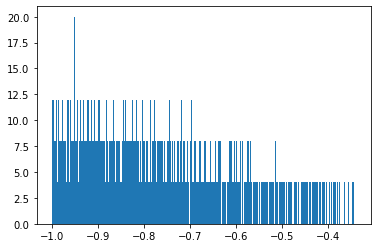

In [29]:
_ = plt.hist(w_truth[np.where(w_truth>-1.0)], bins=500)

In [30]:
om_data = np.load('ensemble_cnn/Patches_Ensemble_results_om.npy',
                 allow_pickle=True).item()['ensemble_pred'][np.where(w_truth>-1.0)]


om_truth_orig =  np.load('ensemble_cnn/Patches_Ensemble_results_om.npy',
                 allow_pickle=True).item()['truth'][np.where(w_truth>-1.0)]

# (data[param] -lo)*s/(hi - lo) + (1 - s)*0.5
hi = 0.5
lo = 0.13
s=0.6

om_truth = (om_truth_orig-(1 - s)*0.5)*(hi-lo)/s + lo

In [31]:
S8_data = np.load('ensemble_cnn/Patches_Ensemble_results_S8.npy',
                 allow_pickle=True).item()['ensemble_pred'][np.where(w_truth>-1.0)]

S8_truth = np.load('ensemble_cnn/Patches_Ensemble_results_S8.npy',
                 allow_pickle=True).item()['truth'][np.where(w_truth>-1.0)]


S8_truth = S8_truth + 0.25

In [32]:
w_datacl = np.load('ensemble_cl/Patches_Ensemble_results_w.npy',
                 allow_pickle=True).item()['ensemble_pred']

w_truthcl = np.load('ensemble_cl/Patches_Ensemble_results_w.npy',
                 allow_pickle=True).item()['truth']


hi = -0.33
lo = -1.8
s=0.6

w_truthcl = (w_truthcl-(1 - s)*0.5)*(hi-lo)/s + lo


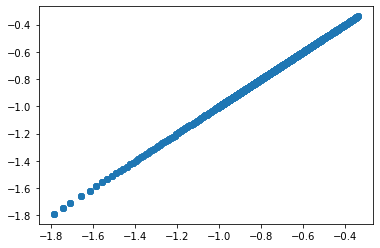

In [33]:
plt.scatter(w_truth,w_truthcl)

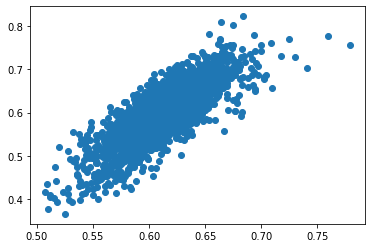

In [34]:
plt.scatter(w_data,w_datacl)

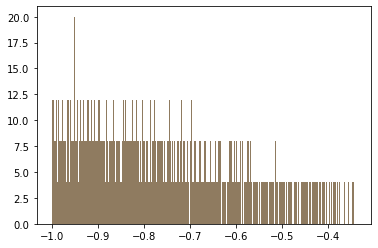

In [35]:
_ = plt.hist(w_truth[np.where(w_truth>-1.0)], bins=500)
_ = plt.hist(w_truthcl[np.where(w_truth>-1.0)], bins=500, alpha=0.5)

In [36]:
om_datacl = np.load('ensemble_cl/Patches_Ensemble_results_om.npy',
                 allow_pickle=True).item()['ensemble_pred'][np.where(w_truth>-1.0)]

om_truthcl = np.load('ensemble_cl/Patches_Ensemble_results_om.npy',
                 allow_pickle=True).item()['truth'][np.where(w_truth>-1.0)]

# (data[param] -lo)*s/(hi - lo) + (1 - s)*0.5
hi = 0.5
lo = 0.13
s=0.6

om_truthcl = (om_truthcl-(1 - s)*0.5)*(hi-lo)/s + lo

In [37]:
S8_datacl = np.load('ensemble_cl/Patches_Ensemble_results_S8.npy',
                 allow_pickle=True).item()['ensemble_pred'][np.where(w_truth>-1.0)]

S8_truthcl = np.load('ensemble_cl/Patches_Ensemble_results_S8.npy',
                 allow_pickle=True).item()['truth'][np.where(w_truth>-1.0)]


S8_truthcl = S8_truthcl + 0.25

(Text(0.5, 0, 'Data compressed'), Text(0, 0.5, 'Data truth'), None)

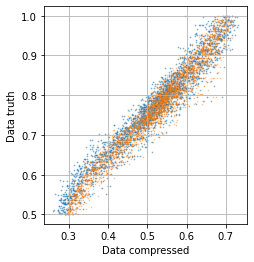

In [38]:
_ = plt.figure(figsize=(8,4))
_ = plt.subplot(121), plt.scatter(S8_datacl, S8_truthcl, marker='.', s=2,alpha=0.5)
_ = plt.subplot(121), plt.scatter(S8_data, S8_truth, marker='.', s=1,alpha=0.5)
plt.xlabel('Data compressed'), plt.ylabel('Data truth'), plt.grid()


(Text(0.5, 0, 'Data compressed'),
 Text(0, 0.5, 'Data truth'),
 None,
 <matplotlib.legend.Legend at 0x13a401300>)

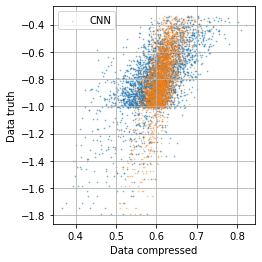

In [39]:
_ = plt.figure(figsize=(8,4))
_ = plt.subplot(121), plt.scatter(w_datacl, w_truthcl, marker='.', s=2,alpha=0.5)
_ = plt.subplot(121), plt.scatter(w_data, w_truth, marker='.', s=1,alpha=0.5, label='CNN')
plt.xlabel('Data compressed'), plt.ylabel('Data truth'), plt.grid(), plt.legend()


(Text(0.5, 0, 'Data compressed'),
 Text(0, 0.5, 'Data truth'),
 None,
 <matplotlib.legend.Legend at 0x12a88f370>)

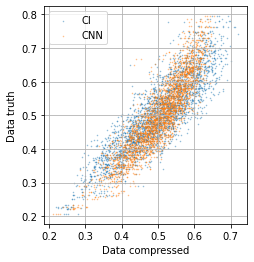

In [40]:
_ = plt.figure(figsize=(8,4))
_ = plt.subplot(121), plt.scatter(om_datacl, om_truth_orig, marker='.', s=1,alpha=0.5, label='Cl')
_ = plt.subplot(121), plt.scatter(om_data, om_truth_orig, marker='.', s=1,alpha=0.5, label='CNN')
# _ = plt.subplot(121), plt.scatter((om_data-0.5)*1.4+0.5, om_truth_orig, marker='.', s=1,alpha=0.5, label='CNN rescaled')
plt.xlabel('Data compressed'), plt.ylabel('Data truth'), plt.grid(), plt.legend()


In [41]:
sim_compressed_data = np.array([S8_data, S8_datacl, om_data, om_datacl,  w_data[np.where(w_truth>-1.0)], w_datacl[np.where(w_truth>-1.0)]]).T
params = np.array([om_truth, S8_truth, w_truth[np.where(w_truth>-1.0)]]).T
compressed_des_mock1 = sim_compressed_data.mean(axis=0)

In [42]:
# Set priors
lower = np.array([0.16, 0.45,-1.0])
upper = np.array([0.52, 1.0,-0.33])
prior = priors.Uniform(lower, upper)

In [43]:
help(ndes.ConditionalMaskedAutoregressiveFlow)

Help on function ConditionalMaskedAutoregressiveFlow in module pydelfi.ndes:

ConditionalMaskedAutoregressiveFlow(n_parameters, n_data, n_mades=1, n_hidden=[50, 50], input_order='random', activation=<keras.layers.activation.leaky_relu.LeakyReLU object at 0x1382085b0>, all_layers=True, kernel_initializer=<keras.initializers.initializers_v2.RandomNormal object at 0x138208700>, bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None)
    Conditional Masked Autoregressive Flow.



In [44]:
tf.__version__

'2.9.2'

In [45]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=3, n_data=6, n_hidden=[50,50], n_mades=4, activation=tf.tanh),
        ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=3, n_data=6, n_hidden=[50,50], n_mades=5, activation=tf.tanh),
        ndes.MixtureDensityNetwork(n_parameters=3, n_data=6, n_components=4, n_hidden=[30,30], activation=[tf.tanh, tf.tanh]),
        ndes.MixtureDensityNetwork(n_parameters=3, n_data=6, n_components=5, n_hidden=[30,30], activation=[tf.tanh, tf.tanh])]


Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(

ValueError: `conditional_input` must be passed as a named argument

In [21]:
DelfiEnsemble = delfi.Delfi(np.array(compressed_des_mock1, dtype = 'float'), prior, NDEs,
                            param_limits = [lower, upper],
                            param_names = ['\Omega_m', 'S_8', 'w'], 
                            results_dir = 'temp_joint5/')


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().





2023-11-29 10:00:20.100734: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 10:00:20.159274: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1996390000 Hz
2023-11-29 10:00:20.161250: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x44efdb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-29 10:00:20.161482: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-29 10:00:20.164271: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [22]:
DelfiEnsemble.load_simulations(np.array(sim_compressed_data, dtype = 'float'), params)

In [23]:
DelfiEnsemble.train_ndes()

Training:   0%|          | 0/500 [00:00<?, ?it/s]

OMP: Info #254: KMP_AFFINITY: pid 783215 tid 784927 thread 1 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 783215 tid 785555 thread 2 bound to OS proc set 2
OMP: Info #254: KMP_AFFINITY: pid 783215 tid 784928 thread 3 bound to OS proc set 3
OMP: Info #254: KMP_AFFINITY: pid 783215 tid 785556 thread 4 bound to OS proc set 4


INFO:tensorflow:Restoring parameters from temp_joint5/graph_checkpoint


Training:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from temp_joint5/graph_checkpoint


Training:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from temp_joint5/graph_checkpoint


Training:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from temp_joint5/graph_checkpoint


# MCMC

In [24]:
import emcee
from chainconsumer import ChainConsumer


import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['image.cmap'] = 'coolwarm'
plt.rc('axes', axisbelow=True)
SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

In [25]:
def initial_parameters(theta, relative_sigma):
    """
    This is not randomise the initial position of the
    :param theta: list/array of parameter values
    :param relative_sigma: controls variance of random draws
    :return: the theta array but with random shifts
    """
    theta = np.array(theta)
    return np.random.normal(theta, np.abs(theta * relative_sigma))

In [48]:
n_dim3d=3
n_burn3d=100
n_steps3d = 10000
n_walkers3d = 2 * n_dim3d

theta3d_expected_mean = [0.3, 0.75, -0.8]

theta0_3d = np.array([list(initial_parameters(theta3d_expected_mean, 0.01)) for i in range(n_walkers3d)])



def prior_term3d(theta3d):
    om, S8, w = theta3d.T
    if ((om<lower[0])|(om>upper[0])):
        return  - np.inf
    if ((S8<lower[1])|(S8>upper[1])):
        return  - np.inf
    if ((w<lower[2])|(w>upper[2])):
        return  - np.inf
    else:
        return  - 0.5*(w+1.)*(w+1.)/(0.3333**2.)
    


def prior_term3d_informative(theta3d):
    om, S8, w = theta3d.T
    if ((om<lower[0])|(om>upper[0])):
        return  - np.inf
    if ((S8<lower[1])|(S8>upper[1])):
        return  - np.inf
    if ((w<lower[2])|(w>upper[2])):
        return  - np.inf
    else:
        return  - 0.5*(w+1.)*(w+1.)/(0.3333**2.) - 0.5*((S8-0.78)/0.07)**2. -  0.5*((om-0.32)/0.065)**2.
    
    


def prior_term3d_flat(theta3d):
    om, S8, w = theta3d.T
    if ((om<lower[0])|(om>upper[0])):
        return  - np.inf
    if ((S8<lower[1])|(S8>upper[1])):
        return  - np.inf
    if ((w<lower[2])|(w>upper[2])):
        return  - np.inf
    else:
        return  0.
                
    

def log_posterior3d_temp(theta3d, data):
    a, b, c = theta3d.T
    return DelfiEnsemble.log_posterior_stacked([a, b, c],data=data)[0][0] + prior_term3d_flat(theta3d)
    # return  prior_term3d_informative(theta3d)
    
    
def log_posterior3d_temp_NDEs(theta3d, data,nde_index):
    a, b, c = theta3d.T
    return DelfiEnsemble.log_posterior_individual(nde_index, [a, b, c],data=data)[0][0] + prior_term3d_flat(theta3d)
    # return  prior_term3d_informative(theta3d)


sampler3d = mc.EnsembleSampler(n_walkers3d, n_dim3d, log_posterior3d_temp,
                             args=(compressed_des_mock1,))


In [27]:
_ = sampler3d.run_mcmc(theta0_3d, n_burn3d+n_steps3d)

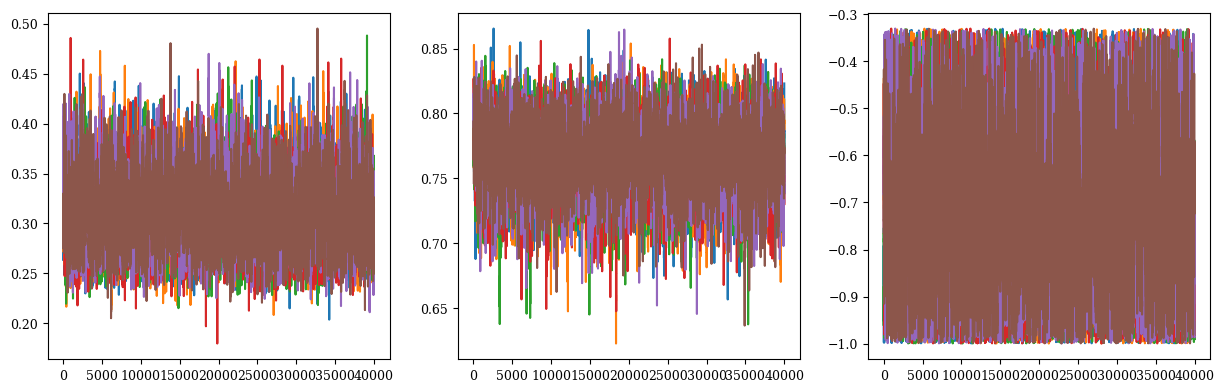

In [28]:
plt.figure(figsize=(15,4.5))
plt.subplot(131)
for i in range(6):
    plt.plot(sampler3d.chain[i,n_burn3d:,0])
plt.subplot(132)
for i in range(6):
    plt.plot(sampler3d.chain[i,n_burn3d:,1])
plt.subplot(133)
for i in range(6):
    plt.plot(sampler3d.chain[i,n_burn3d:,2])

In [29]:
samples3d = sampler3d.get_chain()

In [30]:
np.std(samples3d[n_burn3d:,:,2].flatten())

0.14068648697667085

In [31]:
np.array([om_truth.flatten(), S8_truth.flatten(), w_truth[np.where(w_truth>-1)]]).shape

(3, 2772)

In [32]:
np.save('cnn_chain', np.array([samples3d[n_burn3d:,:,0].flatten(),
             samples3d[n_burn3d:,:,1].flatten(),
             samples3d[n_burn3d:,:,2].flatten()]))

OMP: Info #254: KMP_AFFINITY: pid 909054 tid 927435 thread 5 bound to OS proc set 5


Font size is 62


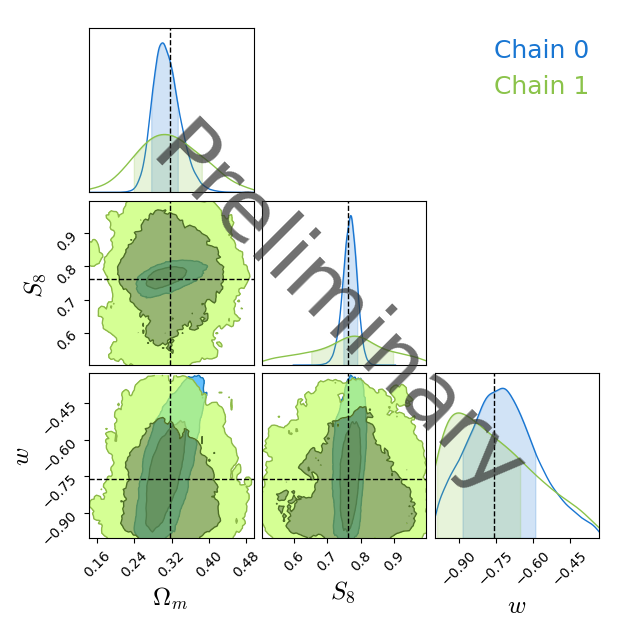

In [33]:
c = ChainConsumer()

c.add_chain([samples3d[n_burn3d:,:,0].flatten(),
             samples3d[n_burn3d:,:,1].flatten(),
             samples3d[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-')

c.add_chain(np.array([om_truth.flatten(), S8_truth.flatten(), w_truth[np.where(w_truth>-1)]]).T,
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-')

c.configure(sigmas = [1,2], label_font_size=18,kde=0.7,flip=False) 


fig = c.plotter.plot(watermark=r'     Preliminary    ',
                     truth=params.mean(axis=0), figsize=(6, 6),filename='./cnn_test_mcmc.pdf')

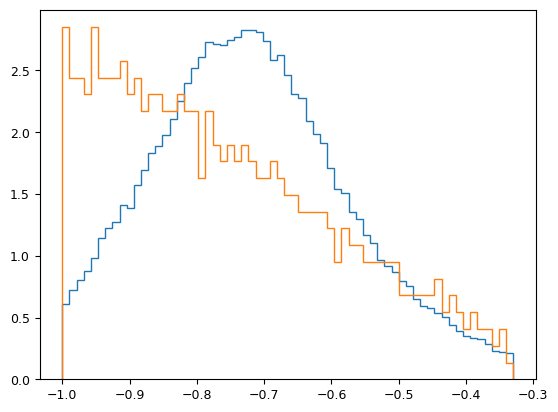

In [34]:
_ = plt.hist(samples3d[n_burn3d:,:,2].flatten(), bins=np.linspace(-1,-0.33,64), histtype='step', density=True)
_ = plt.hist(w_truth, bins=np.linspace(-1,-0.33,64), histtype='step', density=True)

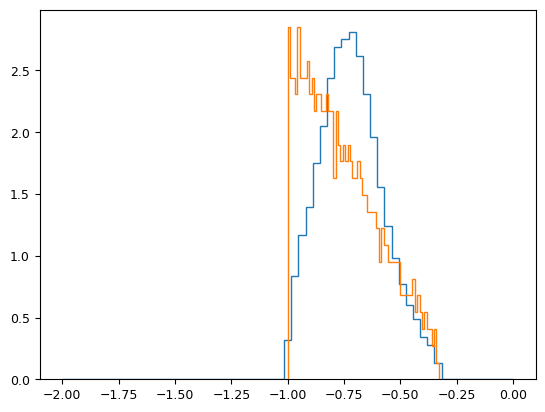

In [35]:
_ = plt.hist(samples3d[n_burn3d:,:,2].flatten(), bins=np.linspace(-2,0,64), histtype='step', density=True)
_ = plt.hist(w_truth, bins=np.linspace(-1,-0.33,64), histtype='step', density=True)

In [36]:

from getdist import plots, MCSamples

In [37]:
samples2 = MCSamples(samples=[samples3d[n_burn3d:,:,0].flatten(),
             samples3d[n_burn3d:,:,1].flatten()],
                                names = ['om','s8'])
           
FOM = 1/np.sqrt(np.linalg.det(samples2.cov()))

Removed no burn in


In [38]:
FOM

1796.4019745123105

Font size is 62


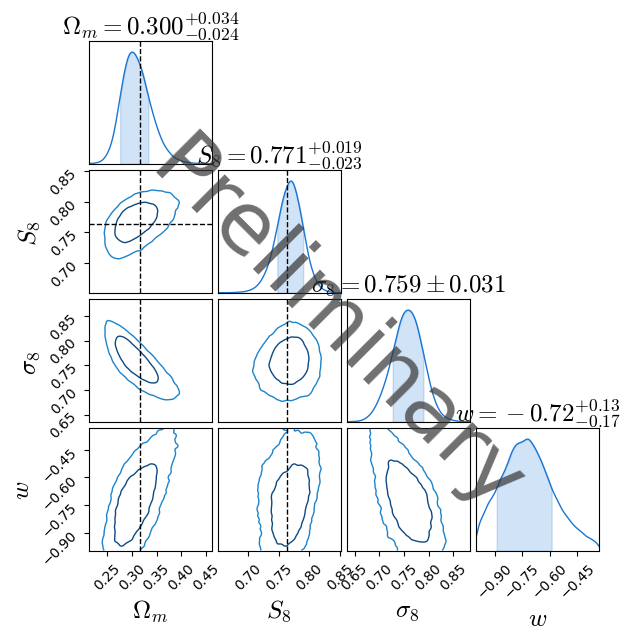

In [39]:
c = ChainConsumer()

c.add_chain([samples3d[n_burn3d:,:,0].flatten(),
             samples3d[n_burn3d:,:,1].flatten(),
             samples3d[n_burn3d:,:,1].flatten()/np.sqrt(samples3d[n_burn3d:,:,0].flatten()/0.3),
             samples3d[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$\sigma_8$', r'$w$'],linestyle = '-')

c.configure(sigmas = [1,2], label_font_size=18,
            shade = [False]*3,flip=False) 

fig = c.plotter.plot(watermark=r'     Preliminary    ',
                     truth=params.mean(axis=0), figsize=(6, 6),filename='./cl_cnn_test_mcmc.pdf')

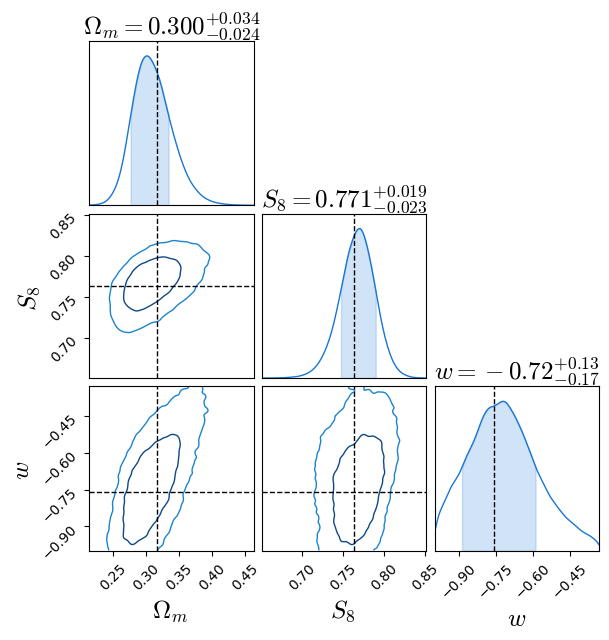

In [143]:
c = ChainConsumer()

c.add_chain([samples3d[n_burn3d:,:,0].flatten(),
             samples3d[n_burn3d:,:,1].flatten(),
             samples3d[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$',r'$w$'],linestyle = '-')

c.configure(sigmas = [1,2], label_font_size=18,
            shade = [False]*3,flip=False) 

fig = c.plotter.plot(truth=params.mean(axis=0), figsize=(6, 6),filename='./cl_cnn_test_mcmc.pdf')

# MCMC no baryon cosmogrid $C_\ell\times$CNN

In [40]:
no_baryon_cosmogrid_cl = np.load('/pscratch/sd/j/joshuaw/Ensemble_Compression_Results/ensemble_patch_compression_cls_JID:17635975/Cosmogrid_No_Baryons_Compression.npy',
                                allow_pickle=True)

In [41]:
no_baryon_cosmogrid_cl

array({'om': {'val_pred': 0.42844802727751197, 'val_truth': 0.41081082820892334}, 'S8': {'val_pred': 0.5261167839631263, 'val_truth': 0.5319974422454834}, 'w': {'val_pred': 0.5558322431578908, 'val_truth': 0.5265306234359741}},
      dtype=object)

In [42]:
no_baryon_cosmogrid_cnn = np.load('/pscratch/sd/j/joshuaw/Ensemble_Compression_Results/ensemble_patch_compression_CNN_JID:17930298/Cosmogrid_No_Baryons_debugged_Compression.npy',
                                allow_pickle=True)

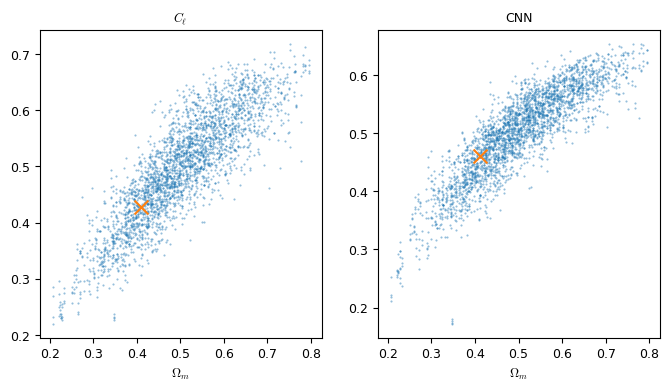

In [43]:
_ = plt.figure(figsize=(8,4))
_ = plt.subplot(121), plt.scatter(om_truth_orig,om_datacl, marker='.', s=1,alpha=0.5, label='Gower street')
_ = plt.xlabel(r'$\Omega_m$')
_ = plt.title(r'$C_\ell$'), plt.scatter(no_baryon_cosmogrid_cl.item()['om']['val_truth'], no_baryon_cosmogrid_cl.item()['om']['val_pred'], marker='x', s=100,label='No baryon mean')
_ = plt.subplot(122), plt.scatter(om_truth_orig,om_data, marker='.', s=1,alpha=0.5, label='CNN')
_ = plt.xlabel(r'$\Omega_m$')
_ = plt.title('CNN'), plt.scatter(no_baryon_cosmogrid_cnn.item()['om']['val_truth'], no_baryon_cosmogrid_cnn.item()['om']['val_pred'], marker='x', s=100,label='No baryon mean')


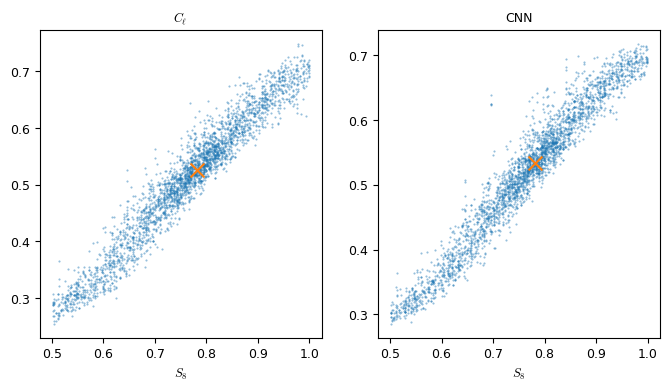

In [44]:
_ = plt.figure(figsize=(8,4))
_ = plt.subplot(121), plt.scatter(S8_truth,S8_datacl, marker='.', s=1,alpha=0.5, label='Gower street')
_ = plt.xlabel(r'$S_8$')
_ = plt.title(r'$C_\ell$'), plt.scatter(no_baryon_cosmogrid_cl.item()['S8']['val_truth']+0.25, no_baryon_cosmogrid_cl.item()['S8']['val_pred'], marker='x', s=100,label='No baryon mean')
_ = plt.subplot(122), plt.scatter(S8_truth,S8_data, marker='.', s=1,alpha=0.5, label='CNN')
_ = plt.xlabel(r'$S_8$')
_ = plt.title('CNN'), plt.scatter(no_baryon_cosmogrid_cnn.item()['S8']['val_truth']+0.25, no_baryon_cosmogrid_cnn.item()['S8']['val_pred'], marker='x', s=100,label='No baryon mean')


In [45]:
compressed_des_no_baryons = np.array([no_baryon_cosmogrid_cnn.item()['S8']['val_pred'],
                                      no_baryon_cosmogrid_cl.item()['S8']['val_pred'],
                                      no_baryon_cosmogrid_cnn.item()['om']['val_pred'],
                                      no_baryon_cosmogrid_cl.item()['om']['val_pred'],
                                      no_baryon_cosmogrid_cnn.item()['w']['val_pred'],
                                      no_baryon_cosmogrid_cl.item()['w']['val_pred']]).T

print(compressed_des_mock1)
print(compressed_des_no_baryons)

[0.51790087 0.51042392 0.50084513 0.49635205 0.61409383 0.60435409]
[0.53415974 0.52611678 0.4607902  0.42844803 0.59630763 0.55583224]


In [46]:
sampler3d_nobaryons = mc.EnsembleSampler(n_walkers3d, n_dim3d, log_posterior3d_temp,
                                         args=(compressed_des_no_baryons,))

# _ = sampler3d_nobaryons.run_mcmc(theta0_3d, n_burn3d+10000)
_ = sampler3d_nobaryons.run_mcmc(theta0_3d, n_burn3d+40000)

In [47]:
samples3d_nobaryons = sampler3d_nobaryons.get_chain()

In [48]:
(no_baryon_cosmogrid_cnn.item()['S8']['val_truth']+0.25)/np.sqrt(no_baryon_cosmogrid_cnn.item()['om']['val_truth'])

1.2200689969129264

In [137]:
no_baryons_truth = [(no_baryon_cosmogrid_cnn.item()['om']['val_truth']-(1 - s)*0.5)*(hi-lo)/s + lo,
                    no_baryon_cosmogrid_cnn.item()['S8']['val_truth']+0.25,
                    no_baryon_cosmogrid_cnn.item()['w']['val_truth']]
                    

In [138]:
no_baryons_truth

[0.26000001072883605, 0.7819974422454834, 0.5265306234359741]

In [139]:
no_baryon_cosmogrid_cnn.item()['S8']['val_truth']+0.25

0.7819974422454834

In [140]:
no_baryons_truth

[0.26000001072883605, 0.7819974422454834, 0.5265306234359741]

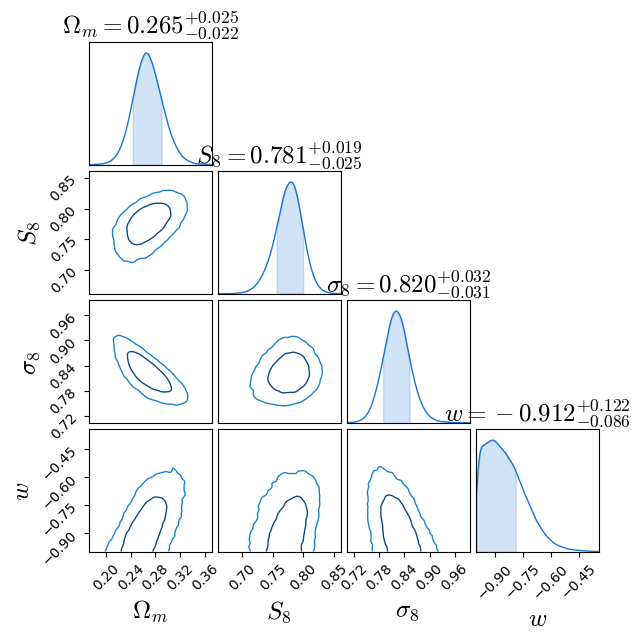

In [141]:
c = ChainConsumer()

c.add_chain([samples3d_nobaryons[n_burn3d:,:,0].flatten(),
             samples3d_nobaryons[n_burn3d:,:,1].flatten(),
             samples3d_nobaryons[n_burn3d:,:,1].flatten()/np.sqrt(samples3d_nobaryons[n_burn3d:,:,0].flatten()/0.3),
             samples3d_nobaryons[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$\sigma_8$', r'$w$'],linestyle = '-', name='No baryons')

c.configure(sigmas = [1,2], label_font_size=18,
            shade = [False]*3,flip=False) 

fig = c.plotter.plot(figsize=(6, 6))

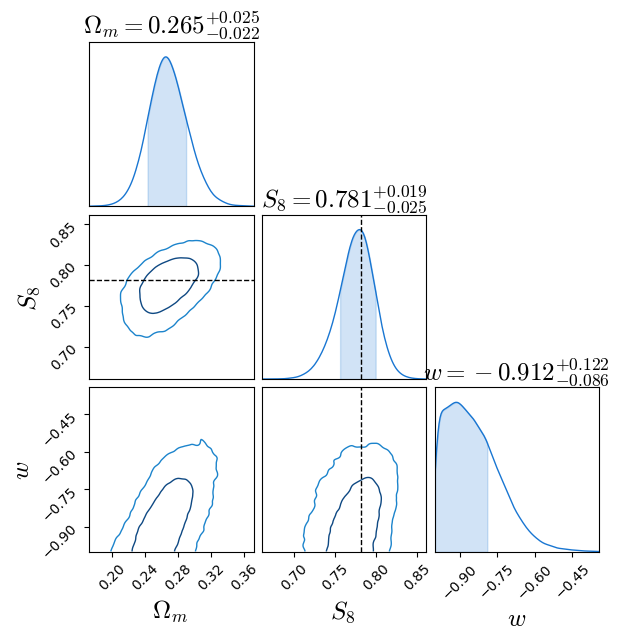

In [116]:
c = ChainConsumer()

c.add_chain([samples3d_nobaryons[n_burn3d:,:,0].flatten(),
             samples3d_nobaryons[n_burn3d:,:,1].flatten(),
             # samples3d_nobaryons[n_burn3d:,:,1].flatten()/np.sqrt(samples3d_nobaryons[n_burn3d:,:,0].flatten()/0.3),
             samples3d_nobaryons[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='No baryons')

c.configure(sigmas = [1,2], label_font_size=18,
            shade = [False]*3,flip=False) 

fig = c.plotter.plot(truth=no_baryons_truth, figsize=(6, 6),filename='./cl_cnn_baryons_mcmc.pdf')

In [54]:
baryon_cosmogrid_cl = np.load('/pscratch/sd/j/joshuaw/Ensemble_Compression_Results/ensemble_patch_compression_cls_JID:17635975/Cosmogrid_Baryons_for_sure_new_Compression.npy',
                                allow_pickle=True)

In [55]:
baryon_cosmogrid_cnn = np.load('/pscratch/sd/j/joshuaw/Ensemble_Compression_Results/ensemble_patch_compression_CNN_JID:17930298/Cosmogrid_Baryons_for_sure_debugged_Compression.npy',
                                allow_pickle=True)

In [56]:
no_baryon_cosmogrid_cnn.item()

{'om': {'val_pred': 0.4607902021214391, 'val_truth': 0.41081082820892334},
 'S8': {'val_pred': 0.534159744086627, 'val_truth': 0.5319974422454834},
 'w': {'val_pred': 0.5963076312637808, 'val_truth': 0.5265306234359741}}

In [57]:
baryon_cosmogrid_cnn.item()

{'om': {'val_pred': 0.459263028186969, 'val_truth': 0.41081082820892334},
 'S8': {'val_pred': 0.5295696383220466, 'val_truth': 0.5319974422454834},
 'w': {'val_pred': 0.5937479223300963, 'val_truth': 0.5265306234359741}}

In [58]:
baryon_cosmogrid_cnn

array({'om': {'val_pred': 0.459263028186969, 'val_truth': 0.41081082820892334}, 'S8': {'val_pred': 0.5295696383220466, 'val_truth': 0.5319974422454834}, 'w': {'val_pred': 0.5937479223300963, 'val_truth': 0.5265306234359741}},
      dtype=object)

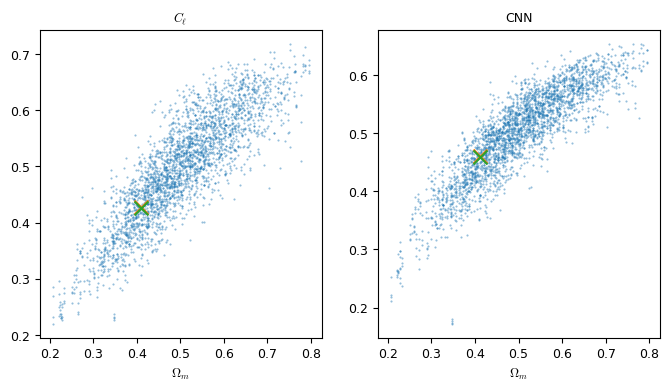

In [59]:
_ = plt.figure(figsize=(8,4))
_ = plt.subplot(121), plt.scatter(om_truth_orig,om_datacl, marker='.', s=1,alpha=0.5, label='Gower street')
_ = plt.xlabel(r'$\Omega_m$')

_ = plt.title(r'$C_\ell$'), plt.scatter(no_baryon_cosmogrid_cl.item()['om']['val_truth'], no_baryon_cosmogrid_cl.item()['om']['val_pred'], marker='x', s=100)

plt.scatter(baryon_cosmogrid_cl.item()['om']['val_truth'], baryon_cosmogrid_cl.item()['om']['val_pred'], marker='x', s=100)

_ = plt.subplot(122), plt.scatter(om_truth_orig,om_data, marker='.', s=1,alpha=0.5, label='CNN')
_ = plt.xlabel(r'$\Omega_m$')
_ = plt.title('CNN'), plt.scatter(no_baryon_cosmogrid_cnn.item()['om']['val_truth'], no_baryon_cosmogrid_cnn.item()['om']['val_pred'], marker='x', s=100,label='No baryon mean')
plt.scatter(baryon_cosmogrid_cnn.item()['om']['val_truth'], baryon_cosmogrid_cnn.item()['om']['val_pred'], marker='x', s=100,label='Baryon mean')


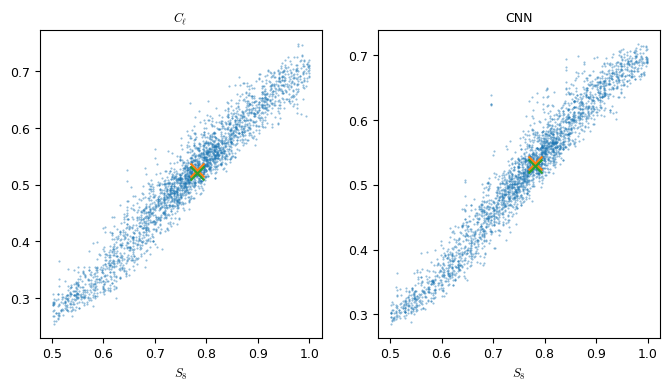

In [60]:
_ = plt.figure(figsize=(8,4))
_ = plt.subplot(121), plt.scatter(S8_truth,S8_datacl, marker='.', s=1,alpha=0.5, label='Gower street')
_ = plt.xlabel(r'$S_8$')
_ = plt.title(r'$C_\ell$'), plt.scatter(no_baryon_cosmogrid_cl.item()['S8']['val_truth']+0.25, no_baryon_cosmogrid_cl.item()['S8']['val_pred'], marker='x', s=100,label='No baryon mean')
plt.scatter(baryon_cosmogrid_cl.item()['S8']['val_truth']+0.25, baryon_cosmogrid_cl.item()['S8']['val_pred'], marker='x', s=100,label='Baryon mean')
_ = plt.subplot(122), plt.scatter(S8_truth,S8_data, marker='.', s=1,alpha=0.5, label='CNN')
_ = plt.xlabel(r'$S_8$')
_ = plt.title('CNN'), plt.scatter(no_baryon_cosmogrid_cnn.item()['S8']['val_truth']+0.25, no_baryon_cosmogrid_cnn.item()['S8']['val_pred'], marker='x', s=100,label='No baryon mean')
plt.scatter(baryon_cosmogrid_cnn.item()['S8']['val_truth']+0.25, baryon_cosmogrid_cnn.item()['S8']['val_pred'], marker='x', s=100,label='Baryon mean')


In [61]:
compressed_des_baryons = np.array([baryon_cosmogrid_cnn.item()['S8']['val_pred'],
                                      baryon_cosmogrid_cl.item()['S8']['val_pred'],
                                      baryon_cosmogrid_cnn.item()['om']['val_pred'],
                                      baryon_cosmogrid_cl.item()['om']['val_pred'],
                                      baryon_cosmogrid_cnn.item()['w']['val_pred'],
                                      baryon_cosmogrid_cl.item()['w']['val_pred']]).T

print(compressed_des_mock1)
print(compressed_des_no_baryons)
print(compressed_des_baryons)

[0.51790087 0.51042392 0.50084513 0.49635205 0.61409383 0.60435409]
[0.53415974 0.52611678 0.4607902  0.42844803 0.59630763 0.55583224]
[0.52956964 0.52137633 0.45926303 0.42566892 0.59374792 0.54778449]


In [62]:
sampler3d_baryons = mc.EnsembleSampler(n_walkers3d, n_dim3d, log_posterior3d_temp,
                                         args=(compressed_des_baryons,))

# _ = sampler3d_baryons.run_mcmc(theta0_3d, n_burn3d+10000)
_ = sampler3d_baryons.run_mcmc(theta0_3d, n_burn3d+40000)

In [63]:
samples3d_baryons = sampler3d_baryons.get_chain()

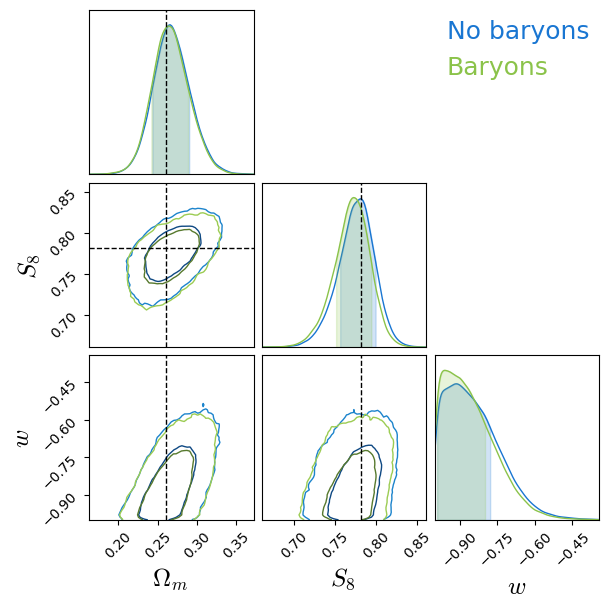

In [64]:
c = ChainConsumer()

c.add_chain([samples3d_nobaryons[n_burn3d:,:,0].flatten(),
             samples3d_nobaryons[n_burn3d:,:,1].flatten(),
             samples3d_nobaryons[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='No baryons')


c.add_chain([samples3d_baryons[n_burn3d:,:,0].flatten(),
             samples3d_baryons[n_burn3d:,:,1].flatten(),
             samples3d_baryons[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='Baryons')

c.configure(sigmas = [1,2], kde=0.8,label_font_size=18,
            shade = [False]*3,flip=False) 

fig = c.plotter.plot(truth=no_baryons_truth, figsize=(6, 6),filename='./cl_cnn_baryons_mcmc.pdf')

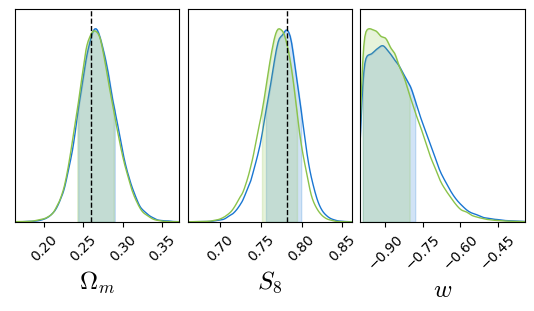

In [65]:


c = ChainConsumer()

c.add_chain([samples3d_nobaryons[n_burn3d:,:,0].flatten(),
             samples3d_nobaryons[n_burn3d:,:,1].flatten(),
             samples3d_nobaryons[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='No baryons')


c.add_chain([samples3d_baryons[n_burn3d:,:,0].flatten(),
             samples3d_baryons[n_burn3d:,:,1].flatten(),
             samples3d_baryons[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='Baryons')

c.configure(sigmas = [1,2], kde=0.6,label_font_size=18,
            shade = [False]*3,flip=False, legend_location=0) 

fig = c.plotter.plot_distributions(truth=no_baryons_truth, figsize=(6, 2.5),filename='./cl_cnn_baryons_mcmc.pdf')

In [66]:
for i in range(3):
    offset = (np.mean(samples3d_nobaryons[n_burn3d:,:,i].flatten()) - np.mean(samples3d_baryons[n_burn3d:,:,i].flatten()))/np.std(samples3d_nobaryons[n_burn3d:,:,i].flatten())
    print(offset)

0.0623387947784048
0.228170486653801
0.1199988910816995


In [67]:
np.mean(samples3d_baryons[n_burn3d:,:,1].flatten())

0.7704604858573406

In [68]:
100*np.mean(samples3d_baryons[n_burn3d:,:,1].flatten())/np.mean(samples3d_nobaryons[n_burn3d:,:,1].flatten()) - 100.

-0.6590324598031856

In [69]:
np.mean(samples3d_nobaryons[n_burn3d:,:,1].flatten())

0.7755717554749861

In [70]:
np.std(samples3d_nobaryons[n_burn3d:,:,1].flatten())

0.022401098812576747

In [71]:
lowbias_cosmogrid_cl = np.load('/pscratch/sd/j/joshuaw/Ensemble_Compression_Results/ensemble_patch_compression_cls_JID:17635975/Cosmogrid_No_Baryons_SCB_05_Compression.npy',
                                allow_pickle=True)

In [72]:
highbias_cosmogrid_cl = np.load('/pscratch/sd/j/joshuaw/Ensemble_Compression_Results/ensemble_patch_compression_cls_JID:17635975/Cosmogrid_No_Baryons_SCB_15_Compression.npy',
                                allow_pickle=True)

In [73]:

lowbias_cosmogrid_cnn = np.load('/pscratch/sd/j/joshuaw/Ensemble_Compression_Results/ensemble_patch_compression_CNN_JID:17930298/Cosmogrid_No_Baryons_SCB_05_Compression.npy',
                                allow_pickle=True)

In [74]:

highbias_cosmogrid_cnn = np.load('/pscratch/sd/j/joshuaw/Ensemble_Compression_Results/ensemble_patch_compression_CNN_JID:17930298/Cosmogrid_No_Baryons_SCB_15_Compression.npy',
                                allow_pickle=True)

In [75]:
no_baryon_cosmogrid_cnn.item()

{'om': {'val_pred': 0.4607902021214391, 'val_truth': 0.41081082820892334},
 'S8': {'val_pred': 0.534159744086627, 'val_truth': 0.5319974422454834},
 'w': {'val_pred': 0.5963076312637808, 'val_truth': 0.5265306234359741}}

In [76]:
lowbias_cosmogrid_cnn.item()

{'om': {'val_pred': 0.45372838304067653, 'val_truth': 0.41081082820892334},
 'S8': {'val_pred': 0.5362152123327056, 'val_truth': 0.5319974422454834},
 'w': {'val_pred': 0.5968832946382463, 'val_truth': 0.5265306234359741}}

In [77]:
highbias_cosmogrid_cnn.item()

{'om': {'val_pred': 0.45454277739239235, 'val_truth': 0.41081082820892334},
 'S8': {'val_pred': 0.5362326521178087, 'val_truth': 0.5319974422454834},
 'w': {'val_pred': 0.5972447535519798, 'val_truth': 0.5265306234359741}}

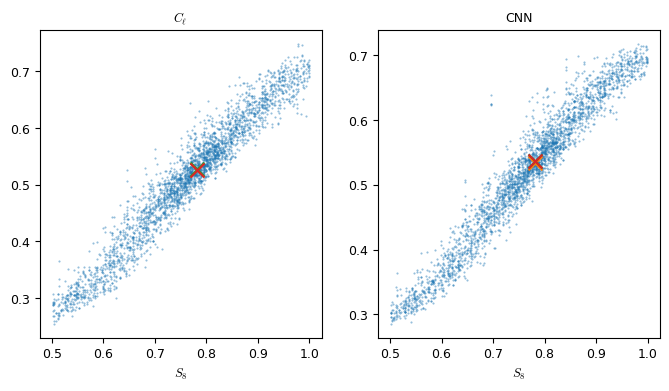

In [78]:
_ = plt.figure(figsize=(8,4))
_ = plt.subplot(121), plt.scatter(S8_truth,S8_datacl, marker='.', s=1,alpha=0.5, label='Gower street')
_ = plt.xlabel(r'$S_8$')
_ = plt.title(r'$C_\ell$'), plt.scatter(no_baryon_cosmogrid_cl.item()['S8']['val_truth']+0.25, no_baryon_cosmogrid_cl.item()['S8']['val_pred'], marker='x', s=100,label='No baryon mean')
plt.scatter(lowbias_cosmogrid_cl.item()['S8']['val_truth']+0.25, lowbias_cosmogrid_cl.item()['S8']['val_pred'], marker='x', s=100,label='Low bias')
plt.scatter(highbias_cosmogrid_cl.item()['S8']['val_truth']+0.25, highbias_cosmogrid_cl.item()['S8']['val_pred'], marker='x', s=100,label='High bias')
_ = plt.subplot(122), plt.scatter(S8_truth,S8_data, marker='.', s=1,alpha=0.5, label='CNN')
_ = plt.xlabel(r'$S_8$')
_ = plt.title('CNN'), plt.scatter(no_baryon_cosmogrid_cnn.item()['S8']['val_truth']+0.25, no_baryon_cosmogrid_cnn.item()['S8']['val_pred'], marker='x', s=100,label='No baryon mean')
plt.scatter(lowbias_cosmogrid_cnn.item()['S8']['val_truth']+0.25, lowbias_cosmogrid_cnn.item()['S8']['val_pred'], marker='x', s=100,label='Low bias')
plt.scatter(highbias_cosmogrid_cnn.item()['S8']['val_truth']+0.25, lowbias_cosmogrid_cnn.item()['S8']['val_pred'], marker='x', s=100,label='High bias')


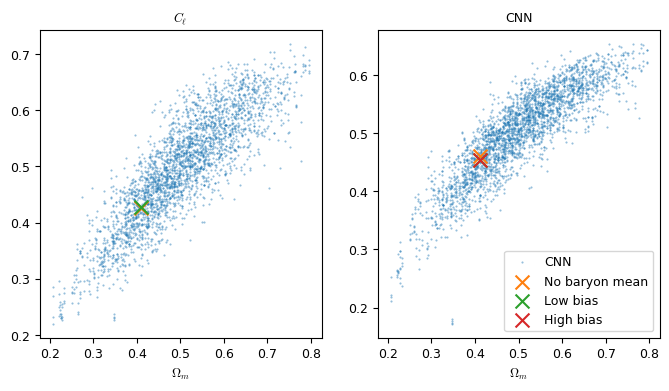

In [79]:
_ = plt.figure(figsize=(8,4))
_ = plt.subplot(121), plt.scatter(om_truth_orig,om_datacl, marker='.', s=1,alpha=0.5, label='Gower street')
_ = plt.xlabel(r'$\Omega_m$')

_ = plt.title(r'$C_\ell$'), plt.scatter(baryon_cosmogrid_cl.item()['om']['val_truth'], baryon_cosmogrid_cl.item()['om']['val_pred'], marker='x', s=100)

plt.scatter(lowbias_cosmogrid_cl.item()['om']['val_truth'], lowbias_cosmogrid_cl.item()['om']['val_pred'], marker='x', s=100)

_ = plt.subplot(122), plt.scatter(om_truth_orig,om_data, marker='.', s=1,alpha=0.5, label='CNN')
_ = plt.xlabel(r'$\Omega_m$')
_ = plt.title('CNN'), plt.scatter(no_baryon_cosmogrid_cnn.item()['om']['val_truth'], no_baryon_cosmogrid_cnn.item()['om']['val_pred'], marker='x', s=100,label='No baryon mean')
plt.scatter(lowbias_cosmogrid_cnn.item()['om']['val_truth'], lowbias_cosmogrid_cnn.item()['om']['val_pred'], marker='x', s=100,label='Low bias')
plt.scatter(lowbias_cosmogrid_cnn.item()['om']['val_truth'], lowbias_cosmogrid_cnn.item()['om']['val_pred'], marker='x', s=100,label='High bias')
plt.legend()


In [80]:
compressed_des_lowbias = np.array([lowbias_cosmogrid_cnn.item()['S8']['val_pred'],
                                      lowbias_cosmogrid_cl.item()['S8']['val_pred'],
                                      lowbias_cosmogrid_cnn.item()['om']['val_pred'],
                                      lowbias_cosmogrid_cl.item()['om']['val_pred'],
                                      lowbias_cosmogrid_cnn.item()['w']['val_pred'],
                                      lowbias_cosmogrid_cl.item()['w']['val_pred']]).T

print(compressed_des_mock1)
print(compressed_des_no_baryons)
print(compressed_des_baryons)
print(compressed_des_lowbias)

[0.51790087 0.51042392 0.50084513 0.49635205 0.61409383 0.60435409]
[0.53415974 0.52611678 0.4607902  0.42844803 0.59630763 0.55583224]
[0.52956964 0.52137633 0.45926303 0.42566892 0.59374792 0.54778449]
[0.53621521 0.52714769 0.45372838 0.42779124 0.59688329 0.55651954]


In [81]:
sampler3d_lowbias = mc.EnsembleSampler(n_walkers3d, n_dim3d, log_posterior3d_temp,
                                         args=(compressed_des_lowbias,))

# _ = sampler3d_lowbias.run_mcmc(theta0_3d, n_burn3d+10000)
_ = sampler3d_lowbias.run_mcmc(theta0_3d, n_burn3d+40000)

In [82]:
samples3d_lowbias = sampler3d_lowbias.get_chain()

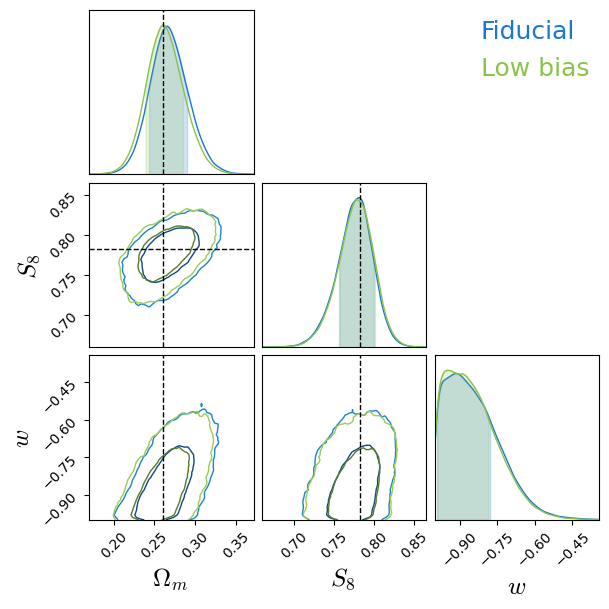

In [83]:
c = ChainConsumer()

c.add_chain([samples3d_nobaryons[n_burn3d:,:,0].flatten(),
             samples3d_nobaryons[n_burn3d:,:,1].flatten(),
             samples3d_nobaryons[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='Fiducial')


c.add_chain([samples3d_lowbias[n_burn3d:,:,0].flatten(),
             samples3d_lowbias[n_burn3d:,:,1].flatten(),
             samples3d_lowbias[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='Low bias')

c.configure(sigmas = [1,2], kde=0.8,label_font_size=18,
            shade = [False]*3,flip=False) 

fig = c.plotter.plot(truth=no_baryons_truth, figsize=(6, 6),filename='./cl_cnn_lowebias_mcmc.pdf')

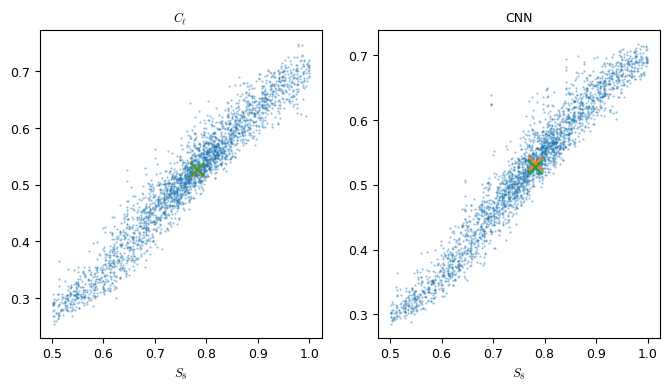

In [84]:
_ = plt.figure(figsize=(8,4))
_ = plt.subplot(121), plt.scatter(S8_truth,S8_datacl, marker='.', s=1,alpha=0.5, label='Gower street')
_ = plt.xlabel(r'$S_8$')
_ = plt.title(r'$C_\ell$'), plt.scatter(no_baryon_cosmogrid_cl.item()['S8']['val_truth']+0.25, no_baryon_cosmogrid_cl.item()['S8']['val_pred'], marker='x', s=100,label='No baryon mean')
plt.scatter(lowbias_cosmogrid_cl.item()['S8']['val_truth']+0.25, lowbias_cosmogrid_cl.item()['S8']['val_pred'], marker='x', s=100,label='Low bias')
_ = plt.subplot(122), plt.scatter(S8_truth,S8_data, marker='.', s=1,alpha=0.5, label='CNN')
_ = plt.xlabel(r'$S_8$')
_ = plt.title('CNN'), plt.scatter(no_baryon_cosmogrid_cnn.item()['S8']['val_truth']+0.25, no_baryon_cosmogrid_cnn.item()['S8']['val_pred'], marker='x', s=100,label='No baryon mean')
plt.scatter(lowbias_cosmogrid_cl.item()['S8']['val_truth']+0.25, lowbias_cosmogrid_cl.item()['S8']['val_pred'], marker='x', s=100,label='Low bias')


In [85]:
compressed_des_highbias = np.array([highbias_cosmogrid_cnn.item()['S8']['val_pred'],
                                      highbias_cosmogrid_cl.item()['S8']['val_pred'],
                                      highbias_cosmogrid_cnn.item()['om']['val_pred'],
                                      highbias_cosmogrid_cl.item()['om']['val_pred'],
                                      highbias_cosmogrid_cnn.item()['w']['val_pred'],
                                      highbias_cosmogrid_cl.item()['w']['val_pred']]).T

print(compressed_des_mock1)
print(compressed_des_no_baryons)
print(compressed_des_baryons)
print(compressed_des_lowbias)
print(compressed_des_highbias)

[0.51790087 0.51042392 0.50084513 0.49635205 0.61409383 0.60435409]
[0.53415974 0.52611678 0.4607902  0.42844803 0.59630763 0.55583224]
[0.52956964 0.52137633 0.45926303 0.42566892 0.59374792 0.54778449]
[0.53621521 0.52714769 0.45372838 0.42779124 0.59688329 0.55651954]
[0.53623265 0.52633745 0.45454278 0.42963566 0.59724475 0.55814331]


In [86]:
sampler3d_highbias = mc.EnsembleSampler(n_walkers3d, n_dim3d, log_posterior3d_temp,
                                         args=(compressed_des_highbias,))

# _ = sampler3d_highbias.run_mcmc(theta0_3d, n_burn3d+10000)
_ = sampler3d_highbias.run_mcmc(theta0_3d, n_burn3d+40000)

In [87]:
samples3d_highbias = sampler3d_highbias.get_chain()

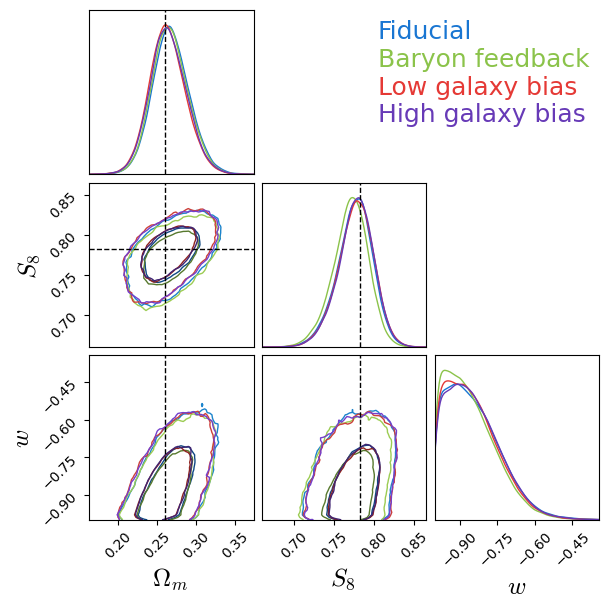

In [88]:
c = ChainConsumer()

c.add_chain([samples3d_nobaryons[n_burn3d:,:,0].flatten(),
             samples3d_nobaryons[n_burn3d:,:,1].flatten(),
             samples3d_nobaryons[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='Fiducial')

c.add_chain([samples3d_baryons[n_burn3d:,:,0].flatten(),
             samples3d_baryons[n_burn3d:,:,1].flatten(),
             samples3d_baryons[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='Baryon feedback')

c.add_chain([samples3d_lowbias[n_burn3d:,:,0].flatten(),
             samples3d_lowbias[n_burn3d:,:,1].flatten(),
             samples3d_lowbias[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='Low galaxy bias')

c.add_chain([samples3d_highbias[n_burn3d:,:,0].flatten(),
             samples3d_highbias[n_burn3d:,:,1].flatten(),
             samples3d_highbias[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='High galaxy bias')


c.configure(sigmas = [1,2], kde=0.8,label_font_size=18,
            shade = [False]*4,flip=False) 

fig = c.plotter.plot(truth=no_baryons_truth, figsize=(6, 6),filename='./cl_cnn_systematics_mcmc.pdf')

In [89]:
psf_cosmogrid_cl = np.load('/pscratch/sd/j/joshuaw/Ensemble_Compression_Results/ensemble_patch_compression_cls_JID:17635975/Cosmogrid_No_Baryons_PSF_Compression.npy',
                                allow_pickle=True)


psf_cosmogrid_cnn = np.load('/pscratch/sd/j/joshuaw/Ensemble_Compression_Results/ensemble_patch_compression_CNN_JID:17930298/Cosmogrid_No_Baryons_PSF_Compression.npy',
                                allow_pickle=True)

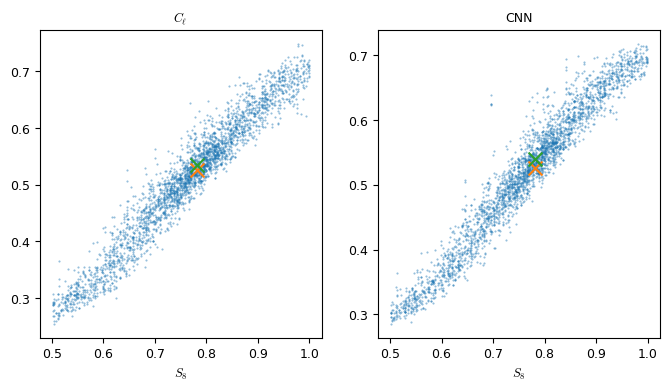

In [90]:
_ = plt.figure(figsize=(8,4))
_ = plt.subplot(121), plt.scatter(S8_truth,S8_datacl, marker='.', s=1,alpha=0.5, label='Gower street')
_ = plt.xlabel(r'$S_8$')
_ = plt.title(r'$C_\ell$'), plt.scatter(no_baryon_cosmogrid_cl.item()['S8']['val_truth']+0.25, no_baryon_cosmogrid_cl.item()['S8']['val_pred'], marker='x', s=100,label='No baryon mean')
plt.scatter(psf_cosmogrid_cl.item()['S8']['val_truth']+0.25, psf_cosmogrid_cl.item()['S8']['val_pred'], marker='x', s=100,label='PSF bias')
_ = plt.subplot(122), plt.scatter(S8_truth,S8_data, marker='.', s=1,alpha=0.5, label='CNN')
_ = plt.xlabel(r'$S_8$')
_ = plt.title('CNN'), plt.scatter(no_baryon_cosmogrid_cl.item()['S8']['val_truth']+0.25, no_baryon_cosmogrid_cl.item()['S8']['val_pred'], marker='x', s=100,label='No baryon mean')
plt.scatter(psf_cosmogrid_cnn.item()['S8']['val_truth']+0.25, psf_cosmogrid_cnn.item()['S8']['val_pred'], marker='x', s=100,label='PSF bias')


In [91]:
compressed_des_psf = np.array([psf_cosmogrid_cnn.item()['S8']['val_pred'],
                                      psf_cosmogrid_cl.item()['S8']['val_pred'],
                                      psf_cosmogrid_cnn.item()['om']['val_pred'],
                                      psf_cosmogrid_cl.item()['om']['val_pred'],
                                      psf_cosmogrid_cnn.item()['w']['val_pred'],
                                      psf_cosmogrid_cl.item()['w']['val_pred']]).T

print(compressed_des_mock1)
print(compressed_des_no_baryons)
print(compressed_des_baryons)
print(compressed_des_lowbias)
print(compressed_des_highbias)
print(compressed_des_psf)

[0.51790087 0.51042392 0.50084513 0.49635205 0.61409383 0.60435409]
[0.53415974 0.52611678 0.4607902  0.42844803 0.59630763 0.55583224]
[0.52956964 0.52137633 0.45926303 0.42566892 0.59374792 0.54778449]
[0.53621521 0.52714769 0.45372838 0.42779124 0.59688329 0.55651954]
[0.53623265 0.52633745 0.45454278 0.42963566 0.59724475 0.55814331]
[0.53984895 0.53480549 0.45934796 0.42027465 0.60215748 0.58114626]


In [92]:
sampler3d_psf = mc.EnsembleSampler(n_walkers3d, n_dim3d, log_posterior3d_temp,
                                         args=(compressed_des_psf,))

_ = sampler3d_psf.run_mcmc(theta0_3d, n_burn3d+40000)

In [93]:
samples3d_psf = sampler3d_psf.get_chain()

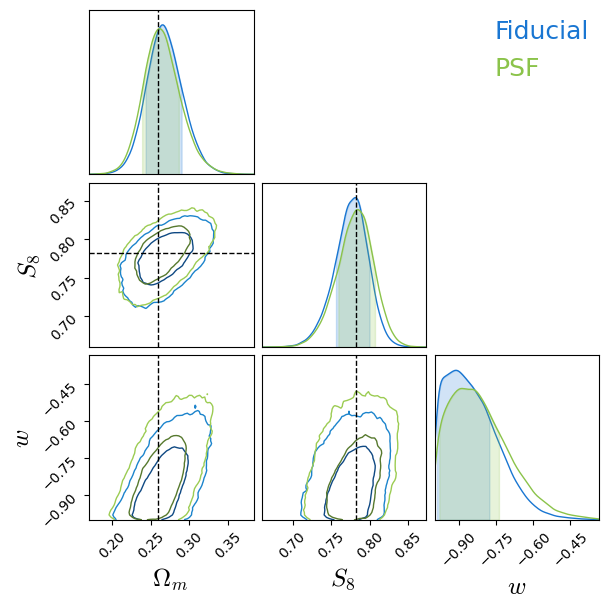

In [94]:
c = ChainConsumer()

c.add_chain([samples3d_nobaryons[n_burn3d:,:,0].flatten(),
             samples3d_nobaryons[n_burn3d:,:,1].flatten(),
             samples3d_nobaryons[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='Fiducial')


c.add_chain([samples3d_psf[n_burn3d:,:,0].flatten(),
             samples3d_psf[n_burn3d:,:,1].flatten(),
             samples3d_psf[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='PSF')

c.configure(sigmas = [1,2], kde=0.8,label_font_size=18,
            shade = [False]*3,flip=False) 

fig = c.plotter.plot(truth=no_baryons_truth, figsize=(6, 6))

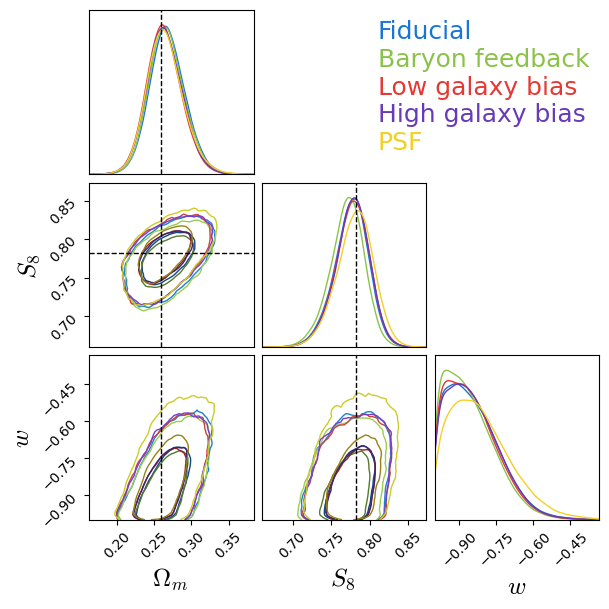

In [103]:
c = ChainConsumer()

c.add_chain([samples3d_nobaryons[n_burn3d:,:,0].flatten(),
             samples3d_nobaryons[n_burn3d:,:,1].flatten(),
             samples3d_nobaryons[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='Fiducial')

c.add_chain([samples3d_baryons[n_burn3d:,:,0].flatten(),
             samples3d_baryons[n_burn3d:,:,1].flatten(),
             samples3d_baryons[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='Baryon feedback')

c.add_chain([samples3d_lowbias[n_burn3d:,:,0].flatten(),
             samples3d_lowbias[n_burn3d:,:,1].flatten(),
             samples3d_lowbias[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='Low galaxy bias')

c.add_chain([samples3d_highbias[n_burn3d:,:,0].flatten(),
             samples3d_highbias[n_burn3d:,:,1].flatten(),
             samples3d_highbias[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='High galaxy bias')

c.add_chain([samples3d_psf[n_burn3d:,:,0].flatten(),
             samples3d_psf[n_burn3d:,:,1].flatten(),
             samples3d_psf[n_burn3d:,:,2].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$', r'$w$'],linestyle = '-', name='PSF')


c.configure(sigmas = [1,2], kde=True,label_font_size=18,
            shade = [False]*5,flip=False) 

fig = c.plotter.plot(truth=no_baryons_truth, figsize=(6, 6),filename='./cl_cnn_systematics_mcmc_full.pdf')

In [113]:
c = ChainConsumer()

c.add_chain([samples3d_nobaryons[n_burn3d:,:,0].flatten(),
             samples3d_nobaryons[n_burn3d:,:,1].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$'],linestyle = '-', name='Fiducial')

c.add_chain([samples3d_baryons[n_burn3d:,:,0].flatten(),
             samples3d_baryons[n_burn3d:,:,1].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$'],linestyle = '-', name='Baryon feedback')

c.add_chain([samples3d_lowbias[n_burn3d:,:,0].flatten(),
             samples3d_lowbias[n_burn3d:,:,1].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$'],linestyle = '-', name='Low galaxy bias')

c.add_chain([samples3d_highbias[n_burn3d:,:,0].flatten(),
             samples3d_highbias[n_burn3d:,:,1].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$'],linestyle = '-', name='High galaxy bias')

c.add_chain([samples3d_psf[n_burn3d:,:,0].flatten(),
             samples3d_psf[n_burn3d:,:,1].flatten()],
            parameters=[r'$\Omega_m$', r'$S_8$',],linestyle = '-', name='PSF')


c.configure(sigmas = [1,2],smoothing=None,label_font_size=18,
            shade = [False]*5,flip=False) 

fig = c.plotter.plot(truth=no_baryons_truth, figsize=(6, 6),filename='./cl_cnn_systematics_mcmc_S8_Om.pdf')

TypeError: configure() got an unexpected keyword argument 'smoothing'

In [95]:
np.save('samples3d_nobaryons',samples3d_nobaryons)
np.save('samples3d_baryons',samples3d_baryons)
np.save('samples3d_lowbias',samples3d_lowbias)
np.save('samples3d_highbias',samples3d_highbias)
np.save('samples3d_psf',samples3d_psf)


# Actual data!

In [28]:
desy3_data_cl = np.load('/pscratch/sd/j/joshuaw/Ensemble_Compression_Results/ensemble_patch_compression_cls_JID:17635975/Cosmogrid_Y3_DATA_Compression.npy',
                                allow_pickle=True)


desy3_data_cnn = np.load('/pscratch/sd/j/joshuaw/Ensemble_Compression_Results/ensemble_patch_compression_CNN_JID:17930298/Cosmogrid_Y3_DATA_Compression.npy',
                                allow_pickle=True)

In [29]:
compressed_des_y3 = np.array([desy3_data_cnn.item()['S8']['val_pred'],
                                      desy3_data_cl.item()['S8']['val_pred'],
                                      desy3_data_cnn.item()['om']['val_pred'],
                                      desy3_data_cl.item()['om']['val_pred'],
                                      desy3_data_cnn.item()['w']['val_pred'],
                                      desy3_data_cl.item()['w']['val_pred']]).T

In [33]:
print(compressed_des_mock1)
# print(compressed_des_no_baryons)
# print(compressed_des_baryons)
# print(compressed_des_lowbias)
# print(compressed_des_highbias)
# print(compressed_des_psf)
print(compressed_des_y3)

[0.51869752 0.51070295 0.50214506 0.49729421 0.61361681 0.60382405]
[0.55187324 0.54917569 0.45586483 0.53134123 0.60495709 0.58857597]


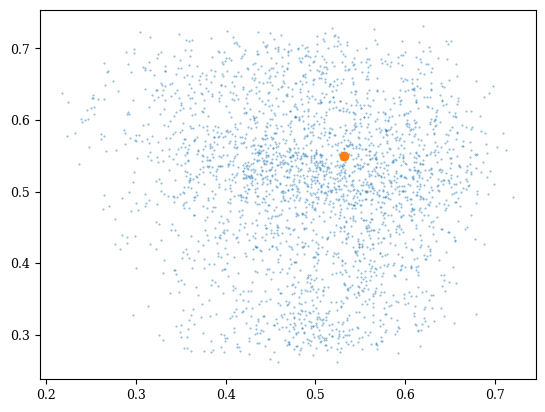

In [34]:
 plt.scatter(om_datacl,S8_datacl, marker='.', s=1,alpha=0.5)
plt.scatter([desy3_data_cl.item()['om']['val_pred']], [desy3_data_cl.item()['S8']['val_pred']])

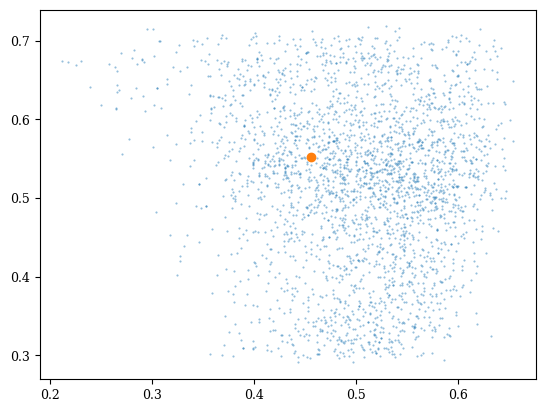

In [35]:
 plt.scatter(om_data,S8_data, marker='.', s=1,alpha=0.5)
plt.scatter([desy3_data_cnn.item()['om']['val_pred']], [desy3_data_cnn.item()['S8']['val_pred']])

In [36]:
sampler3d_data_stacked = mc.EnsembleSampler(n_walkers3d, n_dim3d, log_posterior3d_temp,
                                         args=(compressed_des_y3,))

_ = sampler3d_data_stacked.run_mcmc(theta0_3d, n_burn3d+5000)

In [40]:
samples3d_data_stacked = sampler3d_data_stacked.get_chain()

In [42]:
import getdist
from getdist import plots, MCSamples


Removed no burn in


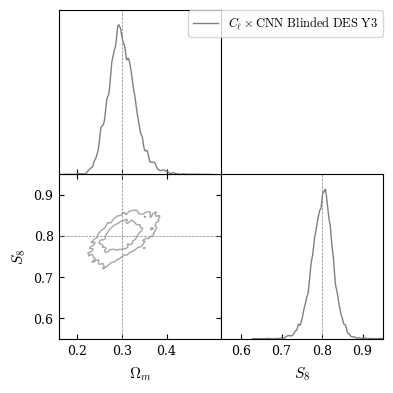

In [47]:
smoothscale1d= 0.08
smoothscale2d = 0.12


labels = ['\Omega_m', 'S_8']
samps1 = np.array([samples3d_data_stacked[n_burn3d:,:,0].flatten()-np.mean(samples3d_data_stacked[n_burn3d:,:,0].flatten())+0.3,
                 samples3d_data_stacked[n_burn3d:,:,1].flatten()-np.mean(samples3d_data_stacked[n_burn3d:,:,1].flatten())+0.8])

samples1 = MCSamples(samples=samps1.T, names=labels, labels=labels,  
                     settings={'mult_bias_correction_order':1,'smooth_scale_2D':smoothscale2d, 'smooth_scale_1D':smoothscale1d})


fig = plots.getSubplotPlotter()
fig.settings.legend_fontsize = 12
fig.settings.axes_fontsize = 12
fig.triangle_plot([samples1], filled=False,
                  legend_labels=[r'$C_\ell \times {\rm CNN\ Blinded\ DES\ Y3}$'],
                  contour_ls=['-','--',':','-.','--'],
                  contour_lws=1.,
                  contour_colors=['gray','C0','C1','C2','C4'],
                  contour_args={'alpha':0.7},
                 param_limits={'\Omega_m':(0.16, 0.52),'S_8':(0.55, .95)})
fig.add_param_markers({'\Omega_m':0.3,'S_8':0.8})
fig.export('fig_blinded')

In [56]:
sampler3d_data_nde0 = mc.EnsembleSampler(n_walkers3d, n_dim3d, log_posterior3d_temp_NDEs,
                                         args=(compressed_des_y3,0))

_ = sampler3d_data_nde0.run_mcmc(theta0_3d, n_burn3d+10000)

samples3d_data_nde0 = sampler3d_data_nde0.get_chain()

sampler3d_data_nde1 = mc.EnsembleSampler(n_walkers3d, n_dim3d, log_posterior3d_temp_NDEs,
                                         args=(compressed_des_y3,1))

_ = sampler3d_data_nde1.run_mcmc(theta0_3d, n_burn3d+10000)

samples3d_data_nde1 = sampler3d_data_nde1.get_chain()

sampler3d_data_nde2 = mc.EnsembleSampler(n_walkers3d, n_dim3d, log_posterior3d_temp_NDEs,
                                         args=(compressed_des_y3,2))

_ = sampler3d_data_nde2.run_mcmc(theta0_3d, n_burn3d+10000)

samples3d_data_nde2 = sampler3d_data_nde2.get_chain()

sampler3d_data_nde3 = mc.EnsembleSampler(n_walkers3d, n_dim3d, log_posterior3d_temp_NDEs,
                                         args=(compressed_des_y3,3))

_ = sampler3d_data_nde3.run_mcmc(theta0_3d, n_burn3d+10000)

samples3d_data_nde3 = sampler3d_data_nde3.get_chain()

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


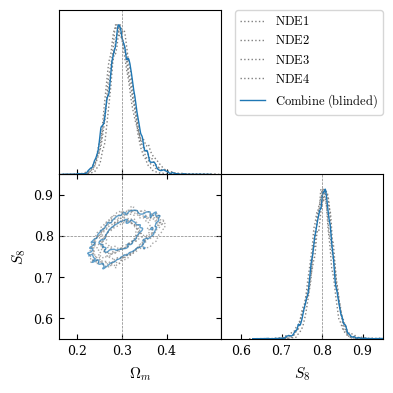

In [66]:
smoothscale1d= 0.08
smoothscale2d = 0.12


labels = ['\Omega_m', 'S_8']
samps1 = np.array([samples3d_data_nde0[n_burn3d:,:,0].flatten()-np.mean(samples3d_data_nde0[n_burn3d:,:,0].flatten())+0.3,
                 samples3d_data_nde0[n_burn3d:,:,1].flatten()-np.mean(samples3d_data_nde0[n_burn3d:,:,1].flatten())+0.8])

samples1 = MCSamples(samples=samps1.T, names=labels, labels=labels,  
                     settings={'mult_bias_correction_order':1,'smooth_scale_2D':smoothscale2d, 'smooth_scale_1D':smoothscale1d})

samps2 = np.array([samples3d_data_nde1[n_burn3d:,:,0].flatten()-np.mean(samples3d_data_nde1[n_burn3d:,:,0].flatten())+0.3,
                 samples3d_data_nde1[n_burn3d:,:,1].flatten()-np.mean(samples3d_data_nde1[n_burn3d:,:,1].flatten())+0.8])

samples2 = MCSamples(samples=samps2.T, names=labels, labels=labels,  
                     settings={'mult_bias_correction_order':1,'smooth_scale_2D':smoothscale2d, 'smooth_scale_1D':smoothscale1d})

samps3 = np.array([samples3d_data_nde2[n_burn3d:,:,0].flatten()-np.mean(samples3d_data_nde2[n_burn3d:,:,0].flatten())+0.3,
                 samples3d_data_nde2[n_burn3d:,:,1].flatten()-np.mean(samples3d_data_nde2[n_burn3d:,:,1].flatten())+0.8])

samples3 = MCSamples(samples=samps3.T, names=labels, labels=labels,  
                     settings={'mult_bias_correction_order':1,'smooth_scale_2D':smoothscale2d, 'smooth_scale_1D':smoothscale1d})

samps4 = np.array([samples3d_data_nde3[n_burn3d:,:,0].flatten()-np.mean(samples3d_data_nde3[n_burn3d:,:,0].flatten())+0.3,
                 samples3d_data_nde3[n_burn3d:,:,1].flatten()-np.mean(samples3d_data_nde3[n_burn3d:,:,1].flatten())+0.8])

samples4 = MCSamples(samples=samps4.T, names=labels, labels=labels,  
                     settings={'mult_bias_correction_order':1,'smooth_scale_2D':smoothscale2d, 'smooth_scale_1D':smoothscale1d})


samps5 = np.array([samples3d_data_stacked[n_burn3d:,:,0].flatten()-np.mean(samples3d_data_stacked[n_burn3d:,:,0].flatten())+0.3,
                 samples3d_data_stacked[n_burn3d:,:,1].flatten()-np.mean(samples3d_data_stacked[n_burn3d:,:,1].flatten())+0.8])

samples5 = MCSamples(samples=samps5.T, names=labels, labels=labels,  
                     settings={'mult_bias_correction_order':1,'smooth_scale_2D':smoothscale2d, 'smooth_scale_1D':smoothscale1d})


fig = plots.getSubplotPlotter()
fig.settings.legend_fontsize = 12
fig.settings.axes_fontsize = 12
fig.triangle_plot([samples1, samples2,samples3,samples4,samples5], filled=False,
                  legend_labels=[r'$\rm NDE 1$',r'$\rm NDE 2$',r'$\rm NDE 3$',r'$\rm NDE 4$',r'$\rm Combine\ (blinded)$'],
                  contour_ls=[':',':',':',':','-'],
                  contour_lws=1.,
                  contour_colors=['gray','gray','gray','gray','C0'],
                  contour_args={'alpha':0.7},
                 param_limits={'\Omega_m':(0.16, 0.52),'S_8':(0.55, .95)})
fig.add_param_markers({'\Omega_m':0.3,'S_8':0.8})
fig.export('fig_blinded_convergence')

In [65]:
samples5.sddev

array([0.03028966, 0.02684572])